<a href="https://colab.research.google.com/github/1Un/MNIST/blob/master/64_10cnn_mnist_lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!






In [2]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
len(y_train), len(y_test)

(60000, 10000)

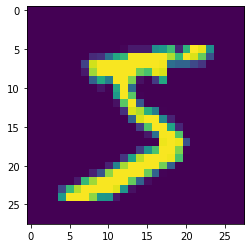

tensor(5)


In [4]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [5]:
X_train.shape


torch.Size([60000, 28, 28])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
X_train.shape
# отличие от полносвязанной сети, которая видела картинку как один вектор длинный,
# мы хотим в конволюционную сеть передавать картинку как трёхмерный тензор.
# Первый канал -- это глубина картинки, в черно-белой картинке это 1
# канал с яркостью серого пикселя. А в RGB картинке будут RGB каналы.
# Соответственно, мы должны нашу картинку, которая на вход пришла (она просто "28 на 28"),
# разжать до "1 на 28 на 28". Вот мы это и делаем -- мы делаем X_train.unsqueeze,
# а здесь ставим индекс: "а в каком же измерении мы хотим разжать".
# То есть X_train у нас -- тензор из 60 000 картинок 28 на 28,
# а мы хотим чтобы было 60 000 на 1 на 28 на 28, и то же самое мы делаем с тестом.

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self,neurons):
        super(LeNet5, self).__init__()
        #conv 2d называется так как матрица у нас двумерная  
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        #изображение в 1 вектор растянем в forward а пока в конструкторе прдеставим что это уже сделано
        self.fc1   = torch.nn.Linear(5 * 5 * 16, neurons)
        self.act3  = torch.nn.Tanh()
        
        # self.fc2   = torch.nn.Linear(neurons, neurons-36)
        # self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(neurons, 10)
    
    #x - входной тензор, т.е. батч из картинок 
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #преобразуем наш тенхор к нужной размерности x.size(0) - размер батча 
        #а дальше тензор одномерный очевидно что бы получить этот размер надо
        #просто перемножить 3 размерности
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        # x = self.fc2(x)
        # x = self.act4(x)
        x = self.fc3(x)
        
        return x
    


In [0]:
# def sum_par(model):
#   s=0
#   for i in model.parameters():
#     #print(i)
#     print(len(i.reshape(-1)))
#     s+=len(i.reshape(-1))
#   return s
# print('sum=',sum_par(lenet5))
#========

# lenet5= LeNet5()
# import torchsummary
# print("Все параметры сети:")
# torchsummary.summary(lenet5.cuda(),(1,28,28))
# #(1,28,28) - размер входного изображения 


def study(lenet5,X_test,y_test,X_train,y_train,batch_size = 5000):  
  #!nvidia-smi
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  lenet5 = lenet5.to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
  

  test_accuracy_history = []
  test_loss_history = []

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  for epoch in range(100):
      order = np.random.permutation(len(X_train))
      for start_index in range(0, len(X_train), batch_size):
          optimizer.zero_grad()
          
          batch_indexes = order[start_index:start_index+batch_size]
          
          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)
          
          preds = lenet5.forward(X_batch) 
          
          loss_value = loss(preds, y_batch)
          loss_value.backward()
          
          optimizer.step()
          
      test_preds = lenet5.forward(X_test)
      test_loss_history.append(loss(test_preds, y_test).data.cpu())

      accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
      test_accuracy_history.append(accuracy)

      if epoch%15==0:
        print('epoch=',epoch,'\taccuracy=',accuracy)
  return test_loss_history,test_accuracy_history
      

In [10]:
test_loss_history=[]
test_accuracy_history=[]
!nvidia-smi
for i in range(64,9,-2):
  lenet5= LeNet5(i)  
  import torchsummary
  print("Все параметры сети:")
  torchsummary.summary(lenet5.cuda(),(1,28,28))
  print('=====',i,'=====')
  test_loss_history1,test_accuracy_history1=study(lenet5,X_test,y_test,X_train,y_train,batch_size = 5000)
  test_loss_history.append(test_loss_history1)
  test_accuracy_history.append(test_accuracy_history1)

Mon Apr 27 09:57:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np

In [0]:
test_loss_history_np=np.array(test_loss_history)
test_accuracy_history_np=np.array(test_accuracy_history)


In [13]:
x1=np.copy(test_loss_history_np)
x2=np.copy(test_accuracy_history_np)
#показание лосс функции на последней эпохе
print(test_loss_history_np[:,-1])



[0.03210466 0.03301898 0.03109245 0.03174412 0.03146103 0.03239636
 0.0304182  0.03378058 0.03251073 0.03429789 0.03119645 0.03398218
 0.0345243  0.03455108 0.03427903 0.03332478 0.03775729 0.03664541
 0.03740745 0.0393565  0.03868147 0.03841249 0.04387629 0.04307655
 0.04770161 0.05159583 0.05831509 0.07479028]


In [14]:
#точность предсказания на последней эпохе 
print(test_accuracy_history_np[:,-1])

[0.9892     0.98829997 0.99069995 0.98889995 0.9896     0.9899
 0.9895     0.9899     0.9891     0.9896     0.99009997 0.98969996
 0.9884     0.98819995 0.9887     0.9896     0.988      0.9888
 0.9881     0.9888     0.98899996 0.9887     0.988      0.9885
 0.98759997 0.98709995 0.98859996 0.98499995]


In [0]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
# save to csv file
savetxt('64-10_test_loss_history_np.csv', test_loss_history_np, delimiter=',')
savetxt('64-10_test_accuracy_history_np.csv', test_accuracy_history_np, delimiter=',')

# load numpy array from csv file
# from numpy import loadtxt
# # load array
# test_loss_history_np = loadtxt('./test_loss_history_np.csv', delimiter=',')
# test_accuracy_history_np = loadtxt('./test_accuracy_history_np.csv', delimiter=',')

In [0]:
# from numpy import genfromtxt
# test_accuracy_history_np = genfromtxt('/content/120-64_test_accuracy_history_np.csv', delimiter=',')
# test_loss_history_np = genfromtxt('/content/120-64_test_loss_history_np.csv', delimiter=',')

максимальная точность на последнй эпохе обучения  0.99069995
минимальная точность  на последнй эпохе обучения 0.98499995


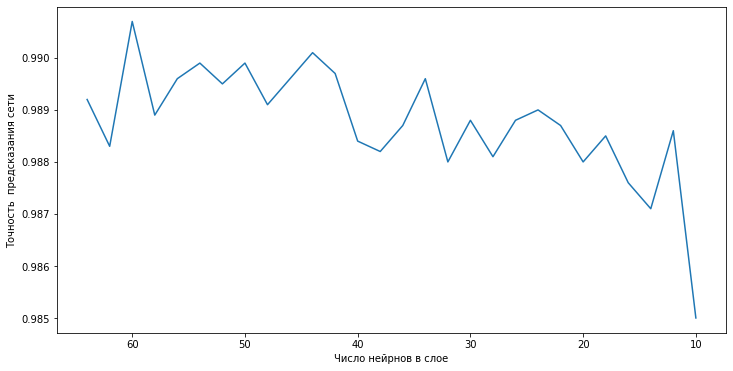

In [27]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(np.arange(64, 9 , -2),test_accuracy_history_np[:,-1])  

plt.gca().invert_xaxis()

ax.set_xlabel('Число нейрнов в слое')

ax.set_ylabel('Точность  предсказания сети')
plt.savefig('4.png')

print('максимальная точность на последнй эпохе обучения ',test_accuracy_history_np[:,-1].max())
#print('т.е. когда число нейронов было ',120-5*(test_accuracy_history_np[:,-1].argmax()+1)) 
print('минимальная точность  на последнй эпохе обучения',test_accuracy_history_np[:,-1].min())
#print('т.е. когда число нейронов было ',120-5*(test_accuracy_history_np[:,-1].argmin())) 